In [71]:
import imageio
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as plti
from scipy.signal import convolve2d
import scipy.stats as st

%matplotlib inline
#notebook

In [2]:
M_YIQ = np.array([[0.299, 0.587, 0.114],
                  [0.595716, -0.274453, -0.321263],
                  [0.211456, -0.522591, 0.311135]])

M_RGB = np.array([[1, 0.9563, 0.6210],
                  [1, -0.2721, -0.6474],
                  [1, -1.1070, 1.7046]])

def apply_matrix(img, M):
    return np.matmul(img.reshape((-1,3)), M.T).reshape(img.shape)

def rgb2yiq(img):
    return apply_matrix(img, M_YIQ)

def yiq2rgb(img):
    return apply_matrix(img, M_RGB)
 

#### Funciones 

In [113]:
#Sampling cada 2 pixeles
def downsampling_x2(img): 
    aux=img[::2,::2]  #Para recorrer una imagen de a 2 pixels en filas y en columnas
    aux=aux[::2,::2]  #Segundo downsampling
    return aux

#Promedio de una cuadrícula de 2x2
def downsampling_avg_x2(img):
    height = img.shape[0] #dimension de la imagen
    width = img.shape[1]
    resized_image=np.zeros(shape=(height//2, width//2))
    #Recorro filas y columnas, desde 0 al alto y ancho con escala de 2 
    for i in range(0, height, 2):
        for j in range(0, width, 2):
             if (i+1<(height//2)*2) & (j+1<(width//2)*2): #Para verificar que no se salga del borde
                resized_image[i//2, j//2] = np.mean(img[i:i+2,j:j+2], axis=(0,1))
                #np.mean suma de los elementos a lo largo del eje dividido por el número de elementos
    return resized_image

#Utilizando la funcion del TP 5
def gaussian(N, sigma=1):
    x = np.linspace(-sigma, sigma, N+1) #linspace crea un vector de valores entre -sigma y sigma igualmente distribuidos
    gaussian_dist = np.diff(st.norm.cdf(x)) #CDF = Cumulative distribution function NORM: distribucion normal/gaussiana.
    gaussian_filter = np.outer(gaussian_dist, gaussian_dist)
    return gaussian_filter/gaussian_filter.sum()

#Filtro gaussiano + sampling cada 2 pixeles
def downsampling_gaussian(img):
    kernel_gaussian = gaussian(9,2) #kernel de orden 9 y con sigma 2 para apreciar mas el efecto
    img_filt = convolve2d(img, kernel_gaussian, mode='full',boundary='symm')
    aux = downsampling_x2(img_filt)
    return aux

#Repetir pixeles en una grilla de 2x2
def upsampling_x2(img):
    height = img.shape[0] #dimension de la imagen
    width = img.shape[1]
    resized_image=np.zeros(shape=(height*2, width*2))
    #Recorro filas y columnas, desde 0 al alto*2 y ancho*2 con escala de 2 
    for i in range(0, height*2, 2):
        for j in range(0, width*2, 2):
            resized_image[i:i+2, j:j+2]=img[i//2,j//2]    
    return resized_image

# A partir del arreglo (bilineal o bicubico) creo un kernel para hacer upsampling bilineal o bicubico.
def bilineal(img):
    #kernel
    arr_aux=[1/2,1,1/2] #Interpolacion Bilineal
    sec=np.expand_dims(arr_aux,1)
    kernel=np.matmul(sec, sec.T)
    img_filt = convolve2d(img, kernel, mode='full',boundary='symm')
    return img_filt

def bicubico(img):
    #kernel
    arr_aux=[-1/8,5/8,1,5/8,-1/8] #Interpolacion Bicubica
    sec=np.expand_dims(arr_aux,1)
    kernel=np.matmul(sec, sec.T)
    img_filt = convolve2d(img, kernel, mode='full',boundary='symm')
    return img_filt

# Repetir pixeles en una grilla de 2x2 y aplicar filtro gaussiano
def upsampling_gaussian(img):
    kernel_gaussian = gaussian(9,2) #kernel de orden 9 y con sigma 2 para apreciar mas el efecto
    aux = upsampling_x2(img)
    img_filt = convolve2d(aux, kernel_gaussian, mode='full',boundary='symm')
    return img_filt

#Calcular la transformada de Fourier de la imagen, recortar los bordes del espectro al tamaño deseado 
#y antitransformar el espectro recortado
def downsampling_fft(img):
    F,C = img.shape
    aux = np.fft.fft2(img) #trasformada discreta 2D de Fourier
    aux = np.fft.fftshift(aux) #para colocar el componente de frecuencia cero al centro del espectro 
    aux_img = aux[F//5:F-F//5, C//5:C-C//5] #recorto un 20% en cada extremo
    N,M = aux_img.shape
    img_out = np.zeros((N,M))
    img_out = np.fft.ifft2(np.fft.ifftshift(aux_img)) #antitransformo 
    return img_out.real #me quedo con la parte real

#Calcular la transformada de Fourier de la imagen, agregar un padding de ceros alrededor del espectro para 
#obtener el tamaño de imagen deseado y antitransformar el espectro con padding
def upsampling_fft(img):
    F,C = img.shape
    aux = np.fft.fft2(img) #trasformada discreta 2D de Fourier
    aux = np.fft.fftshift(aux) #para colocar el componente de frecuencia cero al centro del espectro 
    aux_img = np.pad(aux,((100,100),(100,100)),'constant') #agrego 100 filas por arriba y por abajo y 100 columnas por la izquierda y por la derecha
    N,M = aux_img.shape
    img_out = np.zeros((N,M))
    img_out = np.fft.ifft2(np.fft.ifftshift(aux_img)) #antitransformo 
    return img_out.real #me quedo con la parte real

#Cuantización uniforme
def cuantizacion_uniforme(img,n):
    if((n>1) and (n<255)): #255 limite de la imagen
        n = n-1 #para que me coincida el número de niveles que quiero 
        aux = np.round(img*n)/n
    else:
        print("N debe ser mayor a 1 y menor a 255")
        aux =img
    return aux

#Difusión del error por scanline
def cuantizacion_dithering_scanline(img,n):
    F,C = img.shape
    aux = np.zeros((F,C))
    n = n-1
    for i in range(0,F):
        error = 0
        for j in range(1,C):
            pixel_original = img[i,j].copy()
            pixel_modificado = np.round(pixel_original*n+error)/n
            aux[i,j] = pixel_modificado
            error = error + pixel_original - pixel_modificado
    return aux

#Dithering de Floyd-Steinberg
def cuantizacion_floyd_steinberg(img,n):
    height = img.shape[0] #dimension de la imagen
    width = img.shape[1]
    img_aux=np.array(img, dtype=float)    #Hago una imagen auxiliar para modificarla
    n = n-1
    for i in range(0, height-1): #voy hasta la anteultima fila
        for j in range(0, width-1): #voy hasta la anteultima columna
            pixel_anterior = img_aux[i,j].copy()
            pixel_siguiente = np.round(pixel_anterior*n)/n
            img_aux[i,j] = pixel_siguiente
            error = pixel_anterior - pixel_siguiente
            img_aux[i+1,j] += error*(7/16)
            img_aux[i-1,j+1] += error*(3/16)
            img_aux[i,j+1] += error*(5/16)
            img_aux[i+1,j+1] += error*(1/16)
    return img_aux

#Pseudo codigo: https://es.frwiki.wiki/wiki/Algorithme_de_Floyd-Steinberg

#### DOWNSAMPLING

Text(0.5, 1.0, 'Downsampling cada 2 pixeles + filtro gaussiano')

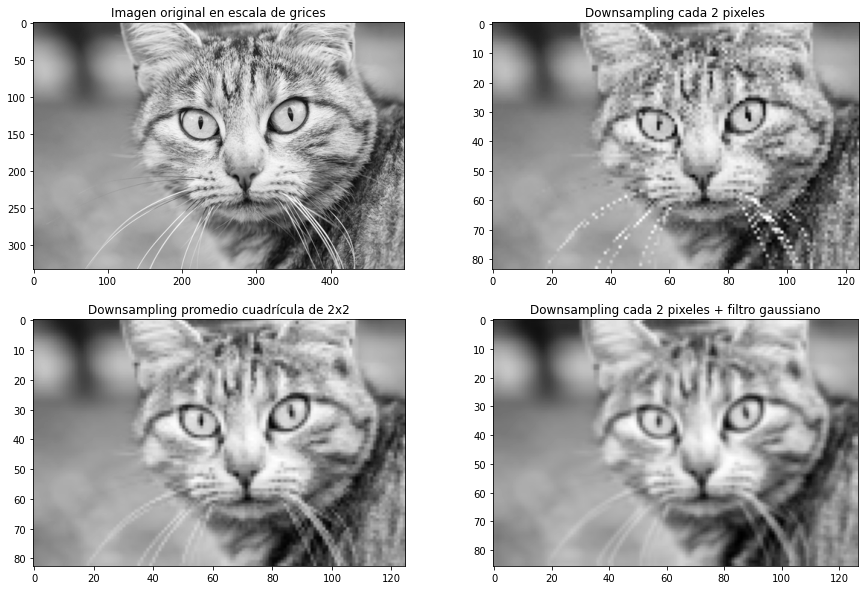

In [101]:
im = imageio.imread("gato.jpg")/255
img = rgb2yiq(im)[:,:,0]

#Downsampling
out_d = downsampling_x2(img)
out_d2 = downsampling_avg_x2(downsampling_avg_x2(img))
out_d3 = downsampling_gaussian(img) 

#graficos
fig, axes = plt.subplots(2, 2, figsize=(15,10))
axes[0,0].imshow(img,'gray')
axes[0,0].set_title("Imagen original en escala de grices")
axes[0,1].imshow(out_d,'gray')
axes[0,1].set_title("Downsampling cada 2 pixeles")
axes[1,0].imshow(out_d2,'gray')
axes[1,0].set_title("Downsampling promedio cuadrícula de 2x2")
axes[1,1].imshow(out_d3,'gray')
axes[1,1].set_title("Downsampling cada 2 pixeles + filtro gaussiano")

#Como era de esperar al reducir el muestreo de la imagen, vamos a obtener imagenes de menor calidad.

#### UPSAMPLING

Text(0.5, 1.0, 'Upsampling grilla de 2x2 + filtro gaussiano')

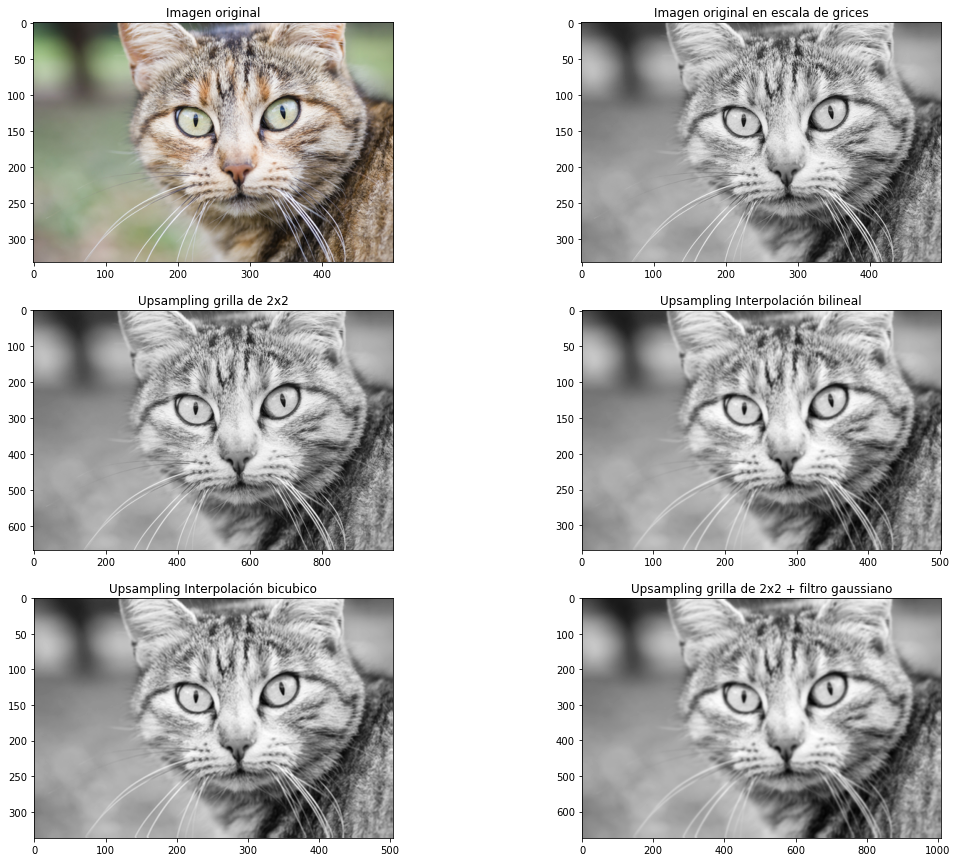

In [114]:
out_u = upsampling_x2(img)
out_u2 = bilineal(img)
out_u3 = bicubico(img)
out_u4 = upsampling_gaussian(img)

#graficos
fig, axes = plt.subplots(3, 2, figsize=(18,15))
axes[0,0].imshow(im)
axes[0,0].set_title("Imagen original")
axes[0,1].imshow(img,'gray')
axes[0,1].set_title("Imagen original en escala de grices")
axes[1,0].imshow(out_u,'gray')
axes[1,0].set_title("Upsampling grilla de 2x2")
axes[1,1].imshow(out_u2,'gray')
axes[1,1].set_title("Upsampling Interpolación bilineal")
axes[2,0].imshow(out_u3,'gray')
axes[2,0].set_title("Upsampling Interpolación bicubico")
axes[2,1].imshow(out_u4,'gray')
axes[2,1].set_title("Upsampling grilla de 2x2 + filtro gaussiano")


#### Upsampling / Downsampling usando FFT

Text(0.5, 1.0, 'Upsampling usando FFT')

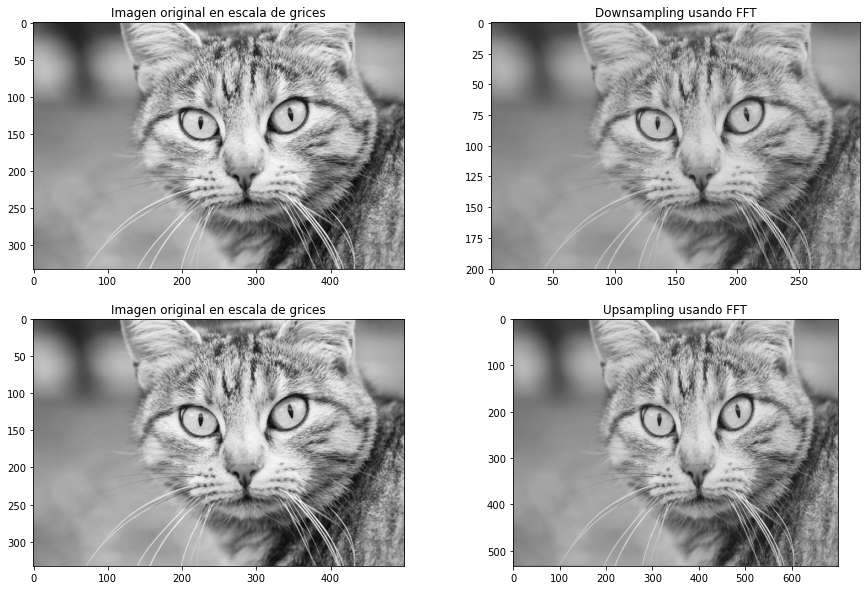

In [84]:
out_d_fft = downsampling_fft(img)
out_u_fft = upsampling_fft(img)

#graficos
fig, axes = plt.subplots(2, 2, figsize=(15,10))
axes[0,0].imshow(img,'gray')
axes[0,0].set_title("Imagen original en escala de grices")
axes[0,1].imshow(out_d_fft,'gray')
axes[0,1].set_title("Downsampling usando FFT")
axes[1,0].imshow(img,'gray')
axes[1,0].set_title("Imagen original en escala de grices")
axes[1,1].imshow(out_u_fft,'gray')
axes[1,1].set_title("Upsampling usando FFT")

#Aqui si se presta atención a los valores de los ejes se puede apreciar el recorte en downsampling y el agregado de pixeles en upsampling.

#### Cuantización

Ingrese el número de niveles de cuantización: 4


Text(0.5, 1.0, 'Dithering de Floyd-Steinberg')

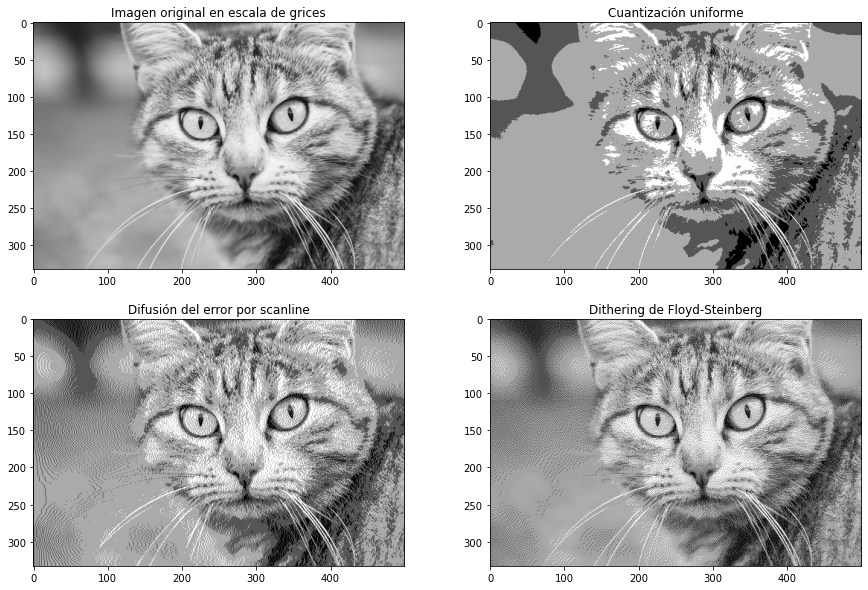

In [110]:
n = int(input("Ingrese el número de niveles de cuantización: ")) 
out_unif = cuantizacion_uniforme(img,n)
out_scanline = cuantizacion_dithering_scanline(img,n)
out_floyd_steinberg = cuantizacion_floyd_steinberg(img,n)

#graficos
fig, axes = plt.subplots(2, 2, figsize=(15,10))
axes[0,0].imshow(img,'gray')
axes[0,0].set_title("Imagen original en escala de grices")
axes[0,1].imshow(out_unif,'gray')
axes[0,1].set_title("Cuantización uniforme")
axes[1,0].imshow(out_scanline,'gray')
axes[1,0].set_title("Difusión del error por scanline")
axes[1,1].imshow(out_floyd_steinberg,'gray')
axes[1,1].set_title("Dithering de Floyd-Steinberg")
#Con este último metodo se logra mayor calidad de imagen.

#Tambien se pudo ver que si se coloca un nivel de cuantizacion de 2, tenemos la imagen formada por blanco y negro, 
#donde en la cuantizacion uniforme se pierde más información de la imagen comparado a los otros 2 metodos. 